In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Raw.csv')

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Rename columns to meet Prophet's requirements
# Prophet requires the columns to be named 'ds' for the datestamp and 'y' for the metric to forecast
prophet_df = df.rename(columns={'date': 'ds', 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)': 'y'})

# Display the first few rows of the DataFrame
prophet_df.head()

,ds,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,y
0,1986-01-01,6748.379,5932.0,47.357,665846.179,122987.5021,55.6511,63.3746,61.7948,72.9945,...,45.557,10.13,11.77,9.53,95.6,71574.0,121947.59,453.7176,18.1213,22.93
1,1986-02-01,6781.198,5962.7,47.240,662058.599,121841.4787,55.2700,62.7722,61.1830,72.3652,...,45.768,10.14,11.80,9.56,95.9,72508.0,123145.20,453.5902,20.6242,15.46
2,1986-03-01,6845.164,6018.8,47.401,662704.671,120996.2216,54.8828,62.5615,60.9771,72.1034,...,45.968,10.15,11.73,9.58,95.1,73685.0,124352.56,450.1009,23.5640,12.61
3,1986-04-01,6868.394,6038.8,47.693,676048.783,121767.8428,54.9456,62.7816,61.0642,72.5823,...,46.051,10.16,11.81,9.56,96.2,75484.0,126113.75,455.0797,23.0154,12.84
4,1986-05-01,6876.660,6043.6,47.980,669565.217,123536.1414,55.0535,62.9988,61.2052,72.9877,...,46.110,10.18,11.86,9.59,94.8,78416.0,129109.91,458.4309,18.8928,15.38


## Model Training and Forecasting

12:24:42 - cmdstanpy - INFO - Chain [1] start processing
12:24:43 - cmdstanpy - INFO - Chain [1] done processing


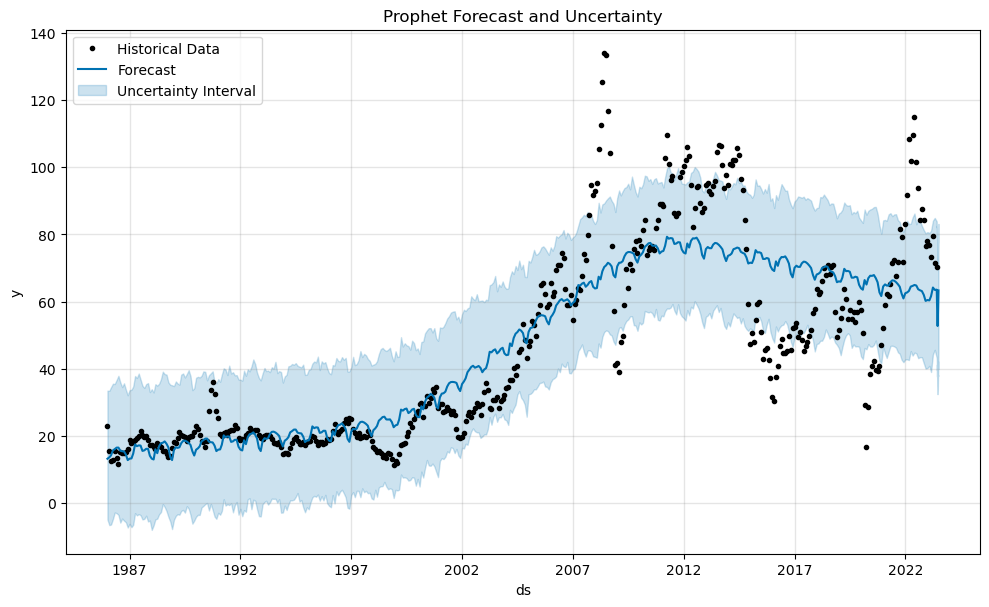

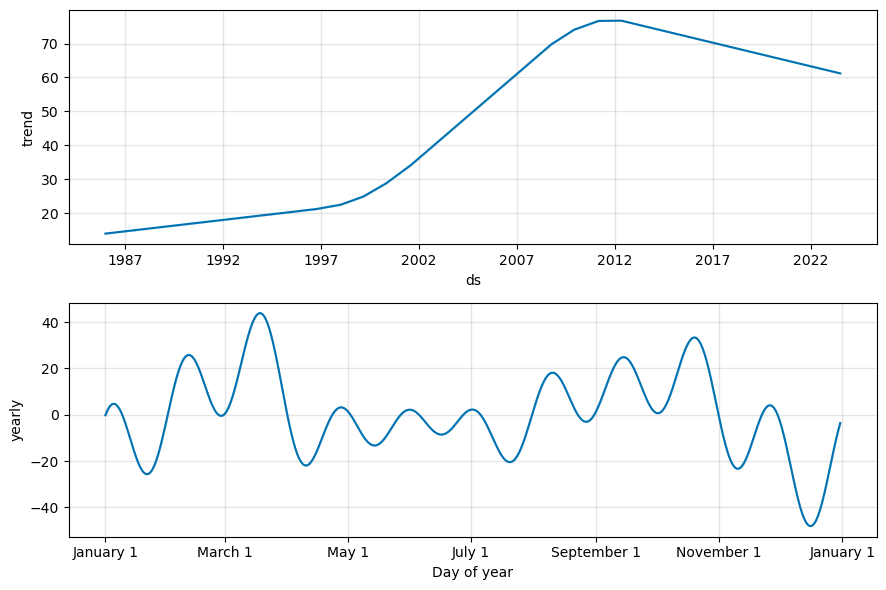

In [2]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future = model.make_future_dataframe(periods=30)

# Generate forecasts
forecast = model.predict(future)

# Plot the historical data and forecasts
fig1 = model.plot(forecast)
plt.legend(labels=['Historical Data', 'Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Prophet Forecast and Uncertainty')
plt.show()

# Plot the components of the forecast (trend, weekly, yearly)
fig2 = model.plot_components(forecast)
plt.show()

- Actual: This represents the actual data points from the dataset.
- Forecast: This is the forecasted values generated by the Prophet model for the future dates.
- Uncertainty Interval: This is the confidence interval around the forecasts, indicating the range within which the actual values are likely to fall with a certain level of confidence.

#### Parameter Tuning - `changepoint_prior_scale` which controls how sensitive the model is to potential changepoints where the trend changes.
- Higher values will make the trend more flexible, lower values will make the trend less flexible.

### Calculate Performance Metrics

In [3]:
# Calculate forecast error metrics using the historical data
y_true = prophet_df['y']
y_pred = forecast.loc[:len(y_true)-1, 'yhat']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Display the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 10.95
Mean Squared Error (MSE): 241.31
Root Mean Squared Error (RMSE): 15.53
R^2 Score: 0.72
Mean Absolute Percentage Error (MAPE): 25.36%


### Parameter Tuning for Changepoint Sensitivity

12:24:44 - cmdstanpy - INFO - Chain [1] start processing
12:24:44 - cmdstanpy - INFO - Chain [1] done processing


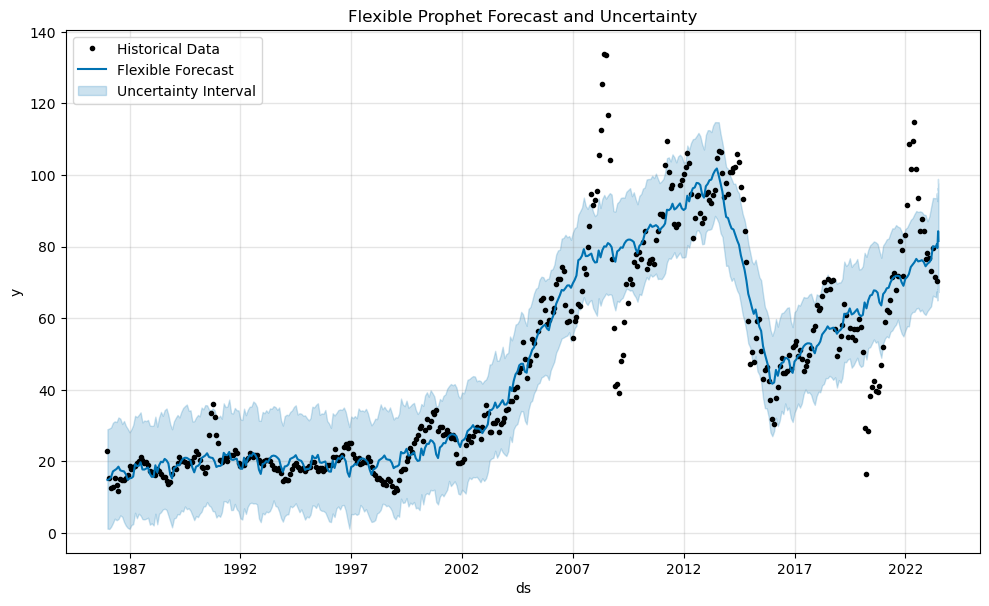

In [4]:
# Tune the changepoint_prior_scale for more flexible trend
flexible_model = Prophet(changepoint_prior_scale=0.5)
flexible_model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future_flexible = flexible_model.make_future_dataframe(periods=30)

# Generate forecasts with the flexible model
forecast_flexible = flexible_model.predict(future_flexible)

# Plot the historical data and the flexible forecasts
fig3 = flexible_model.plot(forecast_flexible)
plt.legend(labels=['Historical Data', 'Flexible Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Flexible Prophet Forecast and Uncertainty')
plt.show()

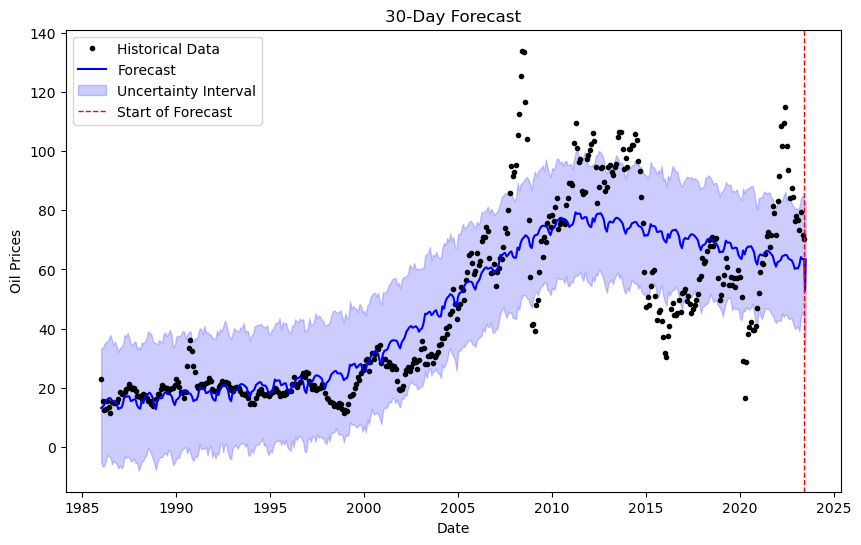

In [5]:
# Plot the forecast for the future 30-day period
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the historical data
ax.plot(prophet_df['ds'], prophet_df['y'], 'k.', label='Historical Data')
# Plot the predicted means as a blue line for the entire forecast period
ax.plot(forecast['ds'], forecast['yhat'], ls='-', color='blue', label='Forecast')
# Plot the prediction intervals as a shaded area for the entire forecast period
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight the 30-day prediction period with a vertical line
ax.axvline(x=prophet_df['ds'].iloc[-1], color='red', linestyle='--', lw=1, label='Start of Forecast')

# Set labels and titles
ax.set_xlabel('Date')
ax.set_ylabel('Oil Prices')
ax.set_title('30-Day Forecast')
ax.legend()

plt.show()

In [6]:
# Check the last date of historical data
last_historical_date = prophet_df['ds'].iloc[-1]
print(f"Last historical date: {last_historical_date}")

# Check the first date of forecast beyond historical data
first_forecasted_date = forecast.loc[len(prophet_df):, 'ds'].iloc[0]
print(f"First forecasted date: {first_forecasted_date}")


Last historical date: 2023-06-01 00:00:00
First forecasted date: 2023-06-02 00:00:00


In [7]:
# Check the future dates in forecast dataframe
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds       yhat  yhat_lower  yhat_upper
475 2023-06-27  60.495493   41.568357   81.354911
476 2023-06-28  61.441629   42.148845   82.112005
477 2023-06-29  62.250744   39.928951   82.734146
478 2023-06-30  62.883662   43.015046   83.122515
479 2023-07-01  63.306126   44.669715   82.810263
